# Watson Decision Platform Layer Visualization

This notebook details the visualisation of the Watson Decision Platform Layers (WDP), using NDVI as an example. For more details on WDP Layers, refer to section 2A here: https://github.com/IBM/watson-decision-platform-for-agriculture/blob/master/docs/pdfs/WDP-Tech-Doc.pdf.

Information about WDP APIs can be seen here: https://foundation.agtech.ibm.com/v2/swagger/

Additional details can be found here: https://github.com/IBM/watson-decision-platform-for-agriculture

_____________________

## Initial set-up

### 1. Get a Bearer Token using an API Key

For invoking Watson Decision Platform APIs, you would first need to retrieve a bearer token corresponding to one of the users that got added into the platform with an API key. The product team will provide customer or tech sales team with API keys as needed. More info at https://ibm.github.io/watson-decision-platform-for-agriculture/api-tokens.html 
 
To get a bearer token using your API key, run the following command in your terminal:

curl --request POST --url https://"token provider URL"/Auth/GetBearerForClient --header 'Content-Type: application/json' --header 'cache-control: no-cache' --data '{apiKey:"xxxxxxxxxxxxxx", clientId:"ibm-agro-api"}'

—> The output that is returned will include an "access_token". **Copy and paste this into 'AUTH_TOKEN' in the code block below.**

### 2. Get a MapBox Access Token
Plese visit their website and follow the directions here: https://docs.mapbox.com/help/glossary/access-token/


### 3. Set the API Endpoint to the Watson Decision Platform Production Endpoint
foundation.agtech.ibm.com/v2


### 4. Run each cell below sequentially (order matters!)

_____________________

In [17]:
AUTH_TOKEN = 'AUTH_TOKEN GOES HERE'
MAPBOX_ACCESS_TOKEN = 'MAPBOX_ACCESS_TOKEN GOES HERE'
API_ENDPOINT = 'API_ENDPOINT GOES HERE'

In [ ]:
!pip install mapboxgl
!conda install -c https://conda.anaconda.org/ioos rasterio --yes
!conda install -c conda-forge libjpeg-turbo --yes

In [19]:
import json

import copy

import pprint

import requests
from requests.exceptions import HTTPError

import os

import matplotlib as mpl
import matplotlib.pyplot as plt

from mapboxgl.viz import *

import rasterio
from rasterio.io import DatasetReader

In [20]:
os.environ["API_ENDPOINT"] = API_ENDPOINT
os.environ["MAPBOX_ACCESS_TOKEN"] = MAPBOX_ACCESS_TOKEN
os.environ["AUTH_TOKEN"]= AUTH_TOKEN

In [21]:
FIELD_MGMT = {
    'host': os.environ.get('API_ENDPOINT', 'Run the notebook to set env vars')
}

FIELD_LAYERS = {
    "host": os.environ.get('API_ENDPOINT', "Run the notebook to set env vars"),
}

HEADERS = {
    'Accept': 'application/json',
    'Authorization': 'Bearer ' + os.environ.get("AUTH_TOKEN", 'Run the notebook to set env vars')
}

LAYER_TYPE = 'NDVIS' #"Normalized Difference Vegetation Index"

LAYER_FORMAT = 'GRID'

FROM_DATE = '2016-01-01'

TO_DATE = '2020-01-01'

MAPBOX_MAP_STYLE = 'mapbox://styles/mapbox/satellite-v9'

PRINTER = pprint.PrettyPrinter(indent = 4)

### Helper Functions

In [22]:
def get_center(geojson):
    
    centroid = geojson["properties"]["centroid"]

    return [centroid['longitude'], centroid['latitude']]


def get_bounds_from_single_feature(geojson): #Using!
    
    box = geojson["properties"]["box"]
    
    north = box["north"]
    east = box["east"]
    south = box["south"]
    west = box["west"]
    
    ul = [west, north]
    ur = [east, north]
    br = [east, south]
    bl = [west, south]
    
    out = [ul, ur, br, bl]
    
    return out


def raster_src_to_png(raster_src):
    png = mpl.image.AxesImage(None)
    png.set_data(raster_src)
    png = png.to_rgba(raster_src[::-1] if png.origin == 'lower' else raster_src, bytes=True, norm=True)
    
    return png

### API Call Functions

In [23]:
def getFields(start=5, limit=10, sort=None, idsOnly=False):
    params = {
        'idsOnly': idsOnly,
        'start': start,
        'limit': limit,
        'sort': sort
    }
    
    get_url = 'https://{}/field'.format(FIELD_MGMT['host'])
    
    r = requests.get(url=get_url, headers=HEADERS,  params=params)    
    return json.loads(r.text) if (r.status_code == 200) else r.raise_for_status()



def getFieldById(field_id):
    get_url = 'https://{}/field/{}'.format(FIELD_MGMT['host'], field_id)
    
    r = requests.get(url=get_url, headers=HEADERS)
    return json.loads(r.text) if (r.status_code == 200) else r.raise_for_status()



def getSubfieldById(subfield_id):
    get_url = 'https://{}/subfield/{}'.format(FIELD_MGMT['host'], subfield_id)

    r = requests.get(url=get_url, headers=HEADERS)
    return json.loads(r.text) if (r.status_code == 200) else r.raise_for_status()



def getLayerStatus(field_id, subfield_id, layer, from_date, to_date, date=None):
    get_url = "https://{}/field/{}/subfield/{}/layer/{}/status".format(FIELD_LAYERS["host"], field_id, subfield_id, layer)
    
    params = {
        'fromDate': from_date,
        'toDate': to_date
    }
    
    if (date is not None):
        get_url = "{}?date={}".format(get_url, date)

    r = requests.get(url=get_url, headers=HEADERS, params=params)
    return json.loads(r.text) if (r.status_code == 200) else r.raise_for_status()



def getLayerData(field_id, subfield_id, layer_type, format_type, date=None, from_date=None, to_date=None):
    get_url = "https://{}/field/{}/subfield/{}/layer/{}/data?format={}".format(FIELD_LAYERS["host"], field_id, subfield_id, layer_type, format_type)

    if (date is not None):
        get_url = "{}&date={}".format(get_url, date)
    
    if (from_date is not None):
         params = {
            'fromDate': from_date,
            'toDate': to_date
        }
        
    headers = copy.deepcopy(HEADERS)
    headers["Accept"] = "application/octet-stream"
        
    r = requests.get(url=get_url, headers=headers)
    
    return r if (r.status_code == 200) else r.raise_for_status()

_____________________

### Fetch a list of all availalable fields

In [24]:
fields = getFields(limit=5)
field_ids = []
for field in fields['features']:
    field_ids.append(field['uuid'])

In [25]:
PRINTER.pprint(field_ids)

[   '0a126d94-695f-41cc-a029-16a748200483',
    '0af8960c-1a02-4a99-8117-da0437a21477',
    '0ba61fc3-d7ce-4338-b77b-94b21092c534',
    '0c5043d3-a2b4-4ea3-9951-8f87e5a0a10c',
    '0d8768ae-364a-41b6-91c7-ce71f6eacdf4']


### With each UUID make an API call to get the field_json.
The function 'getFieldById' makes an API call that returns a geojson for each field, a json object with a specific format for geospatial data.<br>

The geojson includes data about all of the available subfields, which are smaller parcels of land within the defined bounds of the field.<br>

Next, fetch the layer info for the each subfield within the field. This API call returns a list of all layers that are available for viewing and the corresponding date.<br>

In [26]:
all_ready = {}

for field_uuid in field_ids:
    subfields = getFieldById(field_uuid)['subFields']['features']
    field_data = {
        'ready': []
    }
    
    for subfield in subfields:
        layer_info = getLayerStatus(field_uuid, subfield['uuid'], LAYER_TYPE, FROM_DATE, TO_DATE)
        for info in layer_info:
            if info['status'] == 'READY':
                field_data['ready'].append({
                    'sub_id': subfield['uuid'],
                    'date': info['date']
                })
    all_ready[field_uuid] = field_data

In [27]:
PRINTER.pprint(all_ready)

{   '0a126d94-695f-41cc-a029-16a748200483': {   'ready': [   {   'date': '2019-08-04',
                                                                 'sub_id': '8a4c28ab-5e33-4f37-943a-1a9d5c3f6c8a'},
                                                             {   'date': '2019-07-30',
                                                                 'sub_id': '8a4c28ab-5e33-4f37-943a-1a9d5c3f6c8a'},
                                                             {   'date': '2019-07-25',
                                                                 'sub_id': '8a4c28ab-5e33-4f37-943a-1a9d5c3f6c8a'},
                                                             {   'date': '2019-06-15',
                                                                 'sub_id': '8a4c28ab-5e33-4f37-943a-1a9d5c3f6c8a'}]},
    '0af8960c-1a02-4a99-8117-da0437a21477': {'ready': []},
    '0ba61fc3-d7ce-4338-b77b-94b21092c534': {   'ready': [   {   'date': '2019-08-04',
                                        

### Calculations for Visualization

Fetch geojson for the given subfield ID, then calculate the area of that region, center, and bounding box.

The bounding box is the set of coordinates that define the edges of the subfield.

Hover your mouse over the field to see more details.

In [28]:
def field_viz(field_id, subfield_id, index, date):

    subfield_geojson = getSubfieldById(subfield_id)
    area = subfield_geojson["properties"]["area"]
    center = get_center(subfield_geojson)
    field_geojson_bbox = get_bounds_from_single_feature(subfield_geojson)
    layerData = getLayerData(field_id, subfield_id, LAYER_TYPE, LAYER_FORMAT, date)
    
    with open('./data.tif_' + str(index), 'wb') as file:
        file.write(layerData.content)
        
    with rasterio.open('./data.tif_' + str(index)) as dataset:
        raster_geotiff = dataset.read(1, masked=True)
    
    png = raster_src_to_png(raster_geotiff)
    
    print ("*** Date: {} *** Field {} ***".format(date, field_id))
    
    curr_field_viz = ChoroplethViz(subfield_geojson,
                               line_color = "red",
                               line_width = 2,
                               color_property = "area",
                               color_stops = [[area, "pink"]],
                               opacity = 0.6,
                               access_token = MAPBOX_ACCESS_TOKEN,
                               style = MAPBOX_MAP_STYLE,
                               center = center,
                               height = "400px",
                               zoom = 14)
    #curr_field_viz.show()
    
    viz = ImageViz(png,
                   field_geojson_bbox,
                   access_token = MAPBOX_ACCESS_TOKEN,
                   style = MAPBOX_MAP_STYLE,
                   height = "400px",
                   center = center,
                   zoom = 14)
    viz.show()

*** Date: 2019-08-04 *** Field 0a126d94-695f-41cc-a029-16a748200483 ***



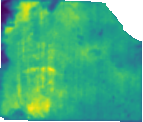

*** Date: 2019-07-30 *** Field 0a126d94-695f-41cc-a029-16a748200483 ***



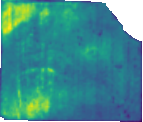

*** Date: 2019-07-25 *** Field 0a126d94-695f-41cc-a029-16a748200483 ***



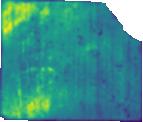

*** Date: 2019-06-15 *** Field 0a126d94-695f-41cc-a029-16a748200483 ***



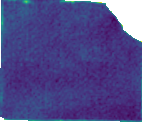

In [29]:
for field, subfields in all_ready.items():
    if len(subfields['ready']) > 0:
        SELECTED_FIELD = field
        for index, subfield in enumerate(subfields['ready']):
            SUBFIELD_ID = subfield['sub_id']
            DATE = subfield['date']
            field_viz(SELECTED_FIELD, SUBFIELD_ID, index, DATE)
    break

### Timeseries Demonstrating Fluctuation of NDVIS

In [30]:
layer_data = getLayerData(SELECTED_FIELD, SUBFIELD_ID, LAYER_TYPE, 'AGGR', None, FROM_DATE, TO_DATE)

In [31]:
min_ndvis = []
max_ndvis = []
avg_ndvis = []
ndvis_date = []

for date in json.loads(layer_data.content):
    min_ndvis.append(date['min'])
    max_ndvis.append(date['max'])
    avg_ndvis.append(date['mean'])
    ndvis_date.append(date['layerDate'])

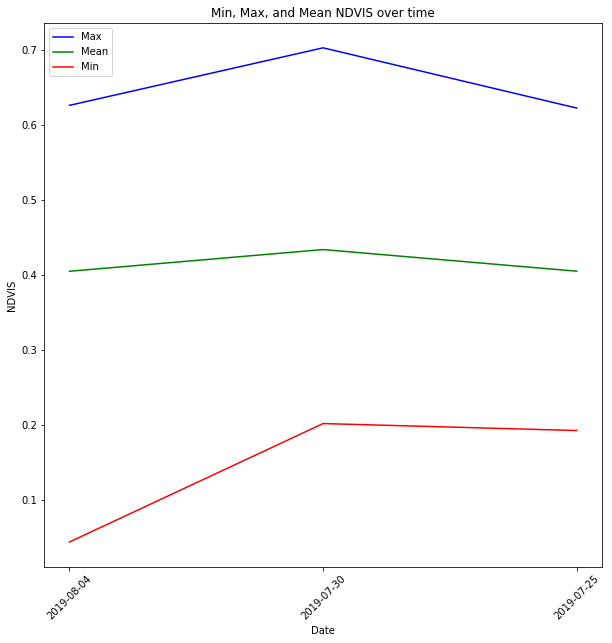

In [34]:
plt.plot(max_ndvis, color = 'blue', label = 'Max')
plt.plot(avg_ndvis, color = 'green', label = 'Mean')
plt.plot(min_ndvis, color = 'red', label = 'Min')
plt.xticks(range(len(ndvis_date)), ndvis_date, rotation=45)
plt.xlabel('Date')
plt.ylabel('NDVIS')
plt.title('Min, Max, and Mean NDVIS over time')
plt.legend(loc="upper left")
plt.rcParams["figure.figsize"] = (1,10)